In [1]:
!nvidia-smi

Tue Dec 12 11:10:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# prompt: CPUのコア数をしらべて
import os
os.cpu_count()

2

In [3]:
class Config:
    name = "exp047" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される

    # Colab Env
    upload_from_colab = False
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/ucbo"

DEBUG = False


In [4]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys


In [5]:
COLAB = "google.colab" in sys.modules
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=f8e12fe7ac3367bc61ae030676c4c7448f5025066bcdc5f0220af3c01d816fc3
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [6]:
if COLAB:
    print("This environment is Google Colab")

    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive')


    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    # set dirs
    DRIVE = Config.drive_path
    EXP = Config.name
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP)
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SCRIPT, OUTPUT, OUTPUT_EXP]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "train.csv")):
    #     # load dataset
    #     ! kaggle competitions download -c UBC-OCEAN -p $INPUT
    #     unzip_file = os.path.join(INPUT, 'UBC-OCEAN.zip')
    #     ! unzip $unzip_file -d $INPUT



This environment is Google Colab
Mounted at /content/drive


In [7]:
%%time
if not DEBUG:
    # tmp fileに直接ダウンロードする
    TMP = '/content/tmp'
    INPUT = '/content/tmp'
    !mkdir $TMP
    files = [
        'tyabanoamami/ucbo-colab-dataset', 'hmendonca/efficientnet-pytorch',
            #  'pjmathematician/ucbo-tiles-256-1', #'tyabanoamami/ucbo-clean-images',
            #  'pjmathematician/ucbo-tiles-256-2', 'pjmathematician/ucbo-tiles-256-3',
            #  'pjmathematician/ucbo-tiles-256-4', 'pjmathematician/ucbo-tiles-256-5',
        'jirkaborovec/tiles-of-cancer-2048px-scale-0-25'
            ]
    for f in files:
        !kaggle datasets download -d $f -p $TMP
        t = f.split('/')[1]
        unzip_file = os.path.join(TMP, f'{t}.zip')
        unzip_file_ = TMP + '/' + t
        INPUT_ = INPUT + '/' + t
        ! unzip $unzip_file -d $unzip_file_
        # !mv $unzip_file_ $INPUT_
        !rm -rf $unzip_file

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7204/000210_3-17.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7204/000211_4-17.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000001_2-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000002_3-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000003_4-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000004_5-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000005_6-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000006_7-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000014_2-2.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000015_3-2.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000016_4-2.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329

# Library

In [8]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install timm

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-405uj8g7
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-405uj8g7
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3863 sha256=0e307f900c1858bc3685eb2cffc21af802178a52e89d886f09c19f497c613227
  Stored in directory: /tmp/pip-ephem-wheel-cache-8zdf__0x/wheels/49/78/e6/9168d5844935482a171c7880a0626fa1c6c412b55666635f59
Successfully built warmup-scheduler
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.8 MB/s eta 0:00:00


In [9]:
import os
import sys
sys.path = [
    os.path.join(INPUT, 'efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'),
] + sys.path

In [10]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm.notebook import tqdm
from sklearn.metrics import balanced_accuracy_score
import timm


In [11]:
# df = pd.read_csv('/content/drive/MyDrive/kaggle/ucbo/Input/tiles-of-cancer-2048px-scale-0-25/train.csv')
# df[df.image_id==int(folders[1].split('/')[-1])].is_tma.values
# from glob import glob
# folders = glob('/content/drive/MyDrive/kaggle/ucbo/Input/tiles-of-cancer-2048px-scale-0-25/*')
# for f in sorted(folders, key=lambda x: int(x.split('/')[-1]) if x.split('/')[-1]!='train.csv' else 999999)[:-1]:
#     tma=False
#     if df[df.image_id==int(f.split('/')[-1])].is_tma.values[0]:
#         tma=True
#     print(f.split('/')[-1], len(glob(f+'/*png')), tma)

# Config

In [12]:
data_dir = os.path.join(INPUT, 'tiles-of-cancer-2048px-scale-0-25')
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')
labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC', 'Other'] #df_train['label'].unique().tolist() + ['Other']
l2n = {v: k for k, v in enumerate(labels)}
n2l = {k: v for k, v in enumerate(labels)}

kernel_type = Config.name

enet_type = 'efficientnet_b0'
fold = 0
# tile_size = 512
image_size = 256
n_tiles = 4 if DEBUG else 9
batch_size = 8
num_workers = os.cpu_count()
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 30
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

import random
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch()

/content/tmp/tiles-of-cancer-2048px-scale-0-25/train_images


# Create Folds

In [13]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[valid_idx, 'fold'] = i
# df_train.head()

In [14]:
def get_image_path(image_id:int):
    # if 4 <= image_id <= 15188:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-1')
    # elif 15209 <= image_id <= 30515:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-2')
    # elif 30539 <= image_id <= 38687:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-3')
    # elif 38849 <= image_id <= 65300:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-4')
    # elif 65371 <= image_id <= 65533:
    #     path = os.path.join(INPUT, 'ucbo-tiles-256-5')
    path = os.path.join(INPUT, 'tiles-of-cancer-2048px-scale-0-25')
    return os.path.join(path, str(image_id))

df_train['tile_path'] = df_train['image_id'].apply(lambda x: get_image_path(x))

# df_train['total_tiles'] = df_train['tile_path'].apply(lambda x: len(os.listdir(x)))
# df_train.head()

# train['clean_tiles'] = train['image_id'].apply(lambda x: len(d[x]))/train['total_tiles']
# train.head()

# Model

In [15]:
# prompt: class enetv2(nn.Module):     def __init__(self, backbone, out_dim):         super(enetv2, self).__init__()         self.enet = enet.EfficientNet.from_name(backbone)         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))          self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)         self.enet._fc = nn.Identity()      def extract(self, x):         return self.enet(x)      def forward(self, x):         x = self.extract(x)         x = self.myfc(x)         return xこのモデルをtimmを使って書き直してください

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = timm.create_model(backbone, pretrained=True)
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x


In [16]:
# model = enetv2('efficientnet_b0', 6)
# model = timm.create_model('efficientnet_b0', pretrained=True)
# model.__dict__['default_cfg']

# Dataset

In [17]:
import joblib
good_images = joblib.load(os.path.join(OUTPUT, 'bw_checker/good_images.pkl'))

In [18]:
def get_tiles(paths):
    ret = []
    for path in paths:
        # PNGファイルを読み込み
        image = PIL.Image.open(path)

        # Pillow ImageオブジェクトをNumPy配列に変換
        image_array = np.array(image)
        ret.append(image_array)
    return ret


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id


        try:
            tiles = good_images[img_id]
        except:
            files = os.listdir(row.tile_path)
            tiles = [row.tile_path + f'/{e}' for e in files]
        if DEBUG:
            tiles = [t.replace('/content/tmp', INPUT) for t in tiles]
        n_imgs = len(tiles)
        tiles = get_tiles(tiles)


        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((self.image_size * n_row_tiles, self.image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w

                # fill all tiles(exp014)
                try:
                    this_img = tiles[idxes[i%n_imgs]]
                    this_img = PIL.Image.fromarray(this_img).resize((self.image_size, self.image_size))
                    this_img = np.array(this_img)
                except:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                # if len(tiles) > idxes[i]:
                #     this_img = tiles[idxes[i]]
                # else:
                #
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * self.image_size
                w1 = w * self.image_size
                images[h1:h1+self.image_size, w1:w1+self.image_size] = this_img

        # if self.transform is not None:
        #     images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        # images /= 255
        images = images.transpose(2, 0, 1)

        # default label
        label = np.zeros(out_dim).astype(np.float32)
        label[l2n[row.label]] = 1.

        #label smoothing(exp006)
        # eps = 0.05
        # label = np.ones(out_dim).astype(np.float32) * eps/out_dim
        # label[l2n[row.label]] += (1. - eps)

        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [19]:
transforms_train = albumentations.Compose([
    albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], # 上のimages /= 255に注意
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.75),
    albumentations.ShiftScaleRotate(p=0.75),
    albumentations.OneOf([
    # albumentations.GaussNoise(var_limit=[10, 50]),
    albumentations.GaussianBlur(),
    albumentations.MotionBlur(),
    ], p=0.3),
    albumentations.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    albumentations.CoarseDropout(max_holes=1, max_width=int(512* 0.2), max_height=int(512* 0.2),
    mask_fill_value=0, p=0.5)
])

transforms_val = albumentations.Compose([
    albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    ])

# efficientnetb0
# 'mean': (0.485, 0.456, 0.406),
#  'std': (0.229, 0.224, 0.225),

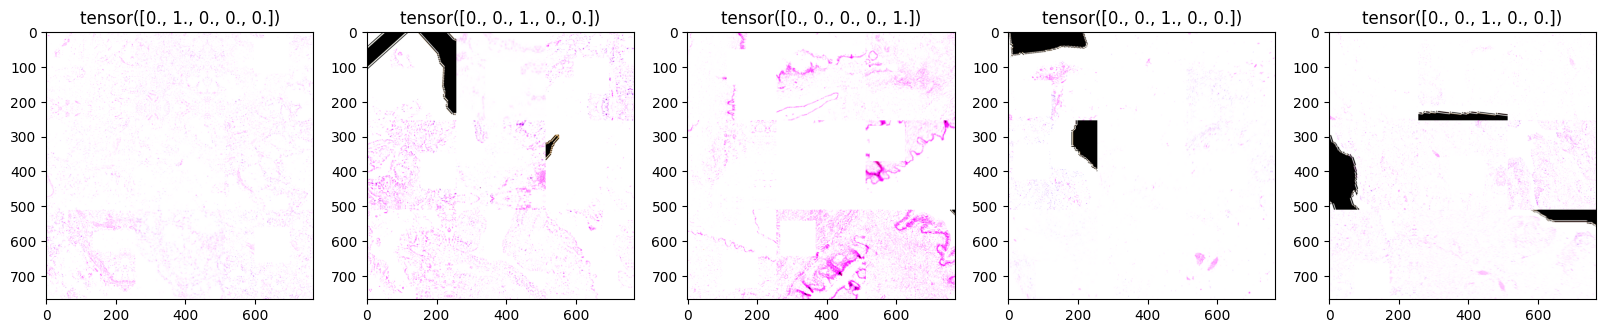

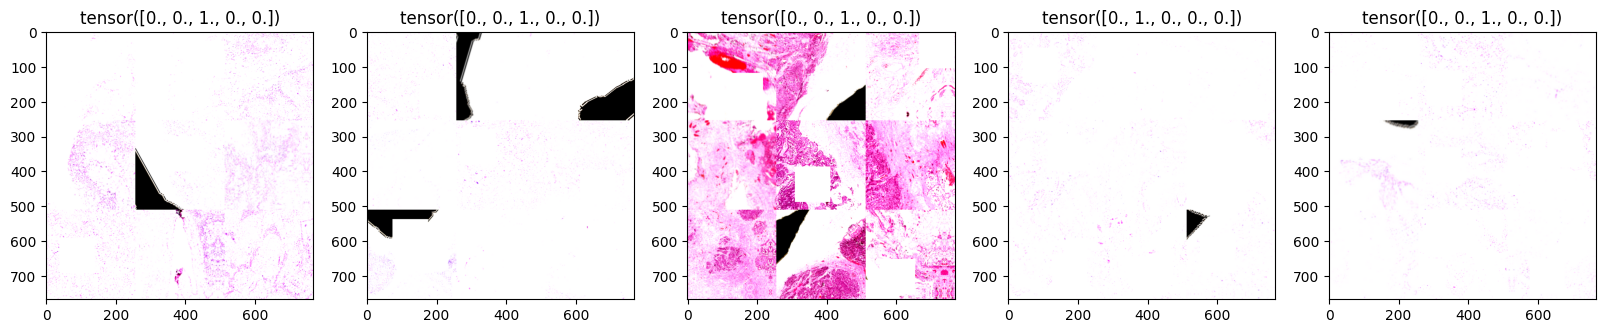

In [20]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(label)


# Loss

In [21]:
# labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC', 'Other'] #df_train['label'].unique().tolist() + ['Other']
# pos_weight = torch.tensor([1.0, 3.0, 3.0, 3.0, 1.0], dtype=torch.float32)
# pos_weight = pos_weight.to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

# Train and Val

In [22]:
# def train_epoch(loader, optimizer):

#     model.train()
#     train_loss = []
#     bar = tqdm(loader)
#     for (data, target) in bar:

#         data, target = data.to(device), target.to(device)
#         loss_func = criterion
#         optimizer.zero_grad()
#         logits = model(data)
#         loss = loss_func(logits, target)
#         loss.backward()
#         optimizer.step()

#         loss_np = loss.detach().cpu().numpy()
#         train_loss.append(loss_np)
#         smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
#         bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
#     return train_loss


# prompt: def train_epoch(loader, optimizer):      model.train()     train_loss = []     bar = tqdm(loader)     for (data, target) in bar:          data, target = data.to(device), target.to(device)         loss_func = criterion         optimizer.zero_grad()         logits = model(data)         loss = loss_func(logits, target)         loss.backward()         optimizer.step()          loss_np = loss.detach().cpu().numpy()         train_loss.append(loss_np)         smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)         bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))     return train_lossをtorch.autocast and torch.cuda.amp.GradScalerをつかって書き換えて

def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    scaler = torch.cuda.amp.GradScaler()
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().detach()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target)

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
#     acc = (PREDS == TARGETS).mean() * 100.
    comp_metric = balanced_accuracy_score(TARGETS.argmax(1), PREDS.argmax(1))
    print(comp_metric)

#     qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
#     qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
#     qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
#     print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, comp_metric, PREDS



# Create Dataloader & Model & Optimizer

In [23]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

430 108


# Run Training

In [24]:
def mymetric(df):
    cols = df['label'].unique().tolist()
    recalls = dict()
    for col in cols:
        df_ = df.query('label==@col')
        recalls[col] = (df_['label']==df_['pred']).sum()/df_.shape[0]
    score = 0
    for k, v in recalls.items():
        score += v
    score /= len(cols)
    return score, recalls

In [ ]:
%%time
comp_metric_max = 0.
best_file = os.path.join(OUTPUT_EXP, f'{kernel_type}_best_fold{fold}.pth')
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, comp_metric, oof_preds = val_epoch(valid_loader)
    df_valid['pred'] = oof_preds.argmax(1)
    df_valid['pred'] = df_valid['pred'].map(n2l)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, balanced accuracy: {(comp_metric):.5f}, '
    content += str(mymetric(df_valid))
    print(content)
    with open(os.path.join(OUTPUT_EXP, f'log_{kernel_type}.txt'), 'a') as appender:
        appender.write(content + '\n')

    if comp_metric > comp_metric_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(comp_metric_max, comp_metric))
        torch.save(model.state_dict(), best_file)
        np.save(os.path.join(OUTPUT_EXP, f'oof_preds_best_fold{fold}.npy'), oof_preds)
        comp_metric_max = comp_metric

torch.save(model.state_dict(), os.path.join(OUTPUT_EXP, f'{kernel_type}_final_fold{fold}.pth'))
np.save(os.path.join(OUTPUT_EXP, f'oof_preds_final_fold{fold}.npy'), oof_preds)
print(f'comp metric max {comp_metric_max}')

Tue Dec 12 11:31:34 2023 Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.22577777777777777
Tue Dec 12 11:49:07 2023 Epoch 1, lr: 0.0000300, train loss: 0.61888, val loss: 0.58385, balanced accuracy: 0.22578, (0.22577777777777777, {'HGSC': 0.6888888888888889, 'CC': 0.0, 'EC': 0.44, 'MC': 0.0, 'LGSC': 0.0})
score2 (0.000000 --> 0.225778).  Saving model ...
Tue Dec 12 11:49:07 2023 Epoch: 2


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.24977777777777774
Tue Dec 12 12:06:25 2023 Epoch 2, lr: 0.0003000, train loss: 0.44167, val loss: 0.53794, balanced accuracy: 0.24978, (0.24977777777777774, {'HGSC': 0.8888888888888888, 'CC': 0.0, 'EC': 0.36, 'MC': 0.0, 'LGSC': 0.0})
score2 (0.225778 --> 0.249778).  Saving model ...
Tue Dec 12 12:06:25 2023 Epoch: 3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.31066666666666665
Tue Dec 12 12:23:47 2023 Epoch 3, lr: 0.0000300, train loss: 0.38081, val loss: 0.44951, balanced accuracy: 0.31067, (0.3106666666666667, {'HGSC': 0.9333333333333333, 'CC': 0.3, 'EC': 0.32, 'MC': 0.0, 'LGSC': 0.0})
score2 (0.249778 --> 0.310667).  Saving model ...
Tue Dec 12 12:23:47 2023 Epoch: 4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.44600000000000006
Tue Dec 12 12:41:03 2023 Epoch 4, lr: 0.0002965, train loss: 0.37779, val loss: 0.40222, balanced accuracy: 0.44600, (0.446, {'HGSC': 0.5777777777777777, 'CC': 0.75, 'EC': 0.68, 'MC': 0.0, 'LGSC': 0.2222222222222222})
score2 (0.310667 --> 0.446000).  Saving model ...
Tue Dec 12 12:41:04 2023 Epoch: 5


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.4846666666666667
Tue Dec 12 12:58:33 2023 Epoch 5, lr: 0.0002921, train loss: 0.36048, val loss: 0.29658, balanced accuracy: 0.48467, (0.48466666666666675, {'HGSC': 0.8, 'CC': 0.65, 'EC': 0.64, 'MC': 0.0, 'LGSC': 0.3333333333333333})
score2 (0.446000 --> 0.484667).  Saving model ...
Tue Dec 12 12:58:33 2023 Epoch: 6


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5942222222222222
Tue Dec 12 13:15:35 2023 Epoch 6, lr: 0.0002861, train loss: 0.35548, val loss: 0.32962, balanced accuracy: 0.59422, (0.5942222222222222, {'HGSC': 0.8, 'CC': 0.5, 'EC': 0.56, 'MC': 0.6666666666666666, 'LGSC': 0.4444444444444444})
score2 (0.484667 --> 0.594222).  Saving model ...
Tue Dec 12 13:15:35 2023 Epoch: 7


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5757777777777777
Tue Dec 12 13:32:34 2023 Epoch 7, lr: 0.0002785, train loss: 0.34276, val loss: 0.30177, balanced accuracy: 0.57578, (0.5757777777777779, {'HGSC': 0.8, 'CC': 0.55, 'EC': 0.64, 'MC': 0.4444444444444444, 'LGSC': 0.4444444444444444})
Tue Dec 12 13:32:34 2023 Epoch: 8


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.49044444444444457
Tue Dec 12 13:49:26 2023 Epoch 8, lr: 0.0002694, train loss: 0.33108, val loss: 0.32744, balanced accuracy: 0.49044, (0.49044444444444435, {'HGSC': 0.9333333333333333, 'CC': 0.35, 'EC': 0.28, 'MC': 0.4444444444444444, 'LGSC': 0.4444444444444444})
Tue Dec 12 13:49:27 2023 Epoch: 9


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6046666666666667
Tue Dec 12 14:06:20 2023 Epoch 9, lr: 0.0002589, train loss: 0.29741, val loss: 0.36341, balanced accuracy: 0.60467, (0.6046666666666668, {'HGSC': 0.8, 'CC': 0.65, 'EC': 0.24, 'MC': 1.0, 'LGSC': 0.3333333333333333})
score2 (0.594222 --> 0.604667).  Saving model ...
Tue Dec 12 14:06:20 2023 Epoch: 10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6235555555555555
Tue Dec 12 14:23:19 2023 Epoch 10, lr: 0.0002471, train loss: 0.28648, val loss: 0.35920, balanced accuracy: 0.62356, (0.6235555555555555, {'HGSC': 0.7333333333333333, 'CC': 0.7, 'EC': 0.24, 'MC': 1.0, 'LGSC': 0.4444444444444444})
score2 (0.604667 --> 0.623556).  Saving model ...
Tue Dec 12 14:23:19 2023 Epoch: 11


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5548888888888889
Tue Dec 12 14:40:40 2023 Epoch 11, lr: 0.0002342, train loss: 0.29010, val loss: 0.34712, balanced accuracy: 0.55489, (0.554888888888889, {'HGSC': 0.9333333333333333, 'CC': 0.25, 'EC': 0.48, 'MC': 0.7777777777777778, 'LGSC': 0.3333333333333333})
Tue Dec 12 14:40:40 2023 Epoch: 12


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.684
Tue Dec 12 14:57:20 2023 Epoch 12, lr: 0.0002203, train loss: 0.27700, val loss: 0.28754, balanced accuracy: 0.68400, (0.6839999999999999, {'HGSC': 0.8666666666666667, 'CC': 0.5, 'EC': 0.72, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
score2 (0.623556 --> 0.684000).  Saving model ...
Tue Dec 12 14:57:20 2023 Epoch: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5777777777777777
Tue Dec 12 15:14:01 2023 Epoch 13, lr: 0.0002055, train loss: 0.26277, val loss: 0.39500, balanced accuracy: 0.57778, (0.5777777777777778, {'HGSC': 0.5555555555555556, 'CC': 0.2, 'EC': 0.8, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 15:14:02 2023 Epoch: 14


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.7146666666666668
Tue Dec 12 15:30:53 2023 Epoch 14, lr: 0.0001901, train loss: 0.26458, val loss: 0.29269, balanced accuracy: 0.71467, (0.7146666666666667, {'HGSC': 0.8, 'CC': 0.6, 'EC': 0.84, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
score2 (0.684000 --> 0.714667).  Saving model ...
Tue Dec 12 15:30:53 2023 Epoch: 15


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.7013333333333334
Tue Dec 12 15:47:48 2023 Epoch 15, lr: 0.0001743, train loss: 0.25267, val loss: 0.28012, balanced accuracy: 0.70133, (0.7013333333333334, {'HGSC': 0.8444444444444444, 'CC': 0.6, 'EC': 0.84, 'MC': 0.7777777777777778, 'LGSC': 0.4444444444444444})
Tue Dec 12 15:47:48 2023 Epoch: 16


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6322222222222222
Tue Dec 12 16:04:41 2023 Epoch 16, lr: 0.0001581, train loss: 0.24679, val loss: 0.35962, balanced accuracy: 0.63222, (0.6322222222222222, {'HGSC': 0.7777777777777778, 'CC': 0.65, 'EC': 0.4, 'MC': 1.0, 'LGSC': 0.3333333333333333})
Tue Dec 12 16:04:41 2023 Epoch: 17


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.7091111111111112
Tue Dec 12 16:21:31 2023 Epoch 17, lr: 0.0001419, train loss: 0.22835, val loss: 0.26995, balanced accuracy: 0.70911, (0.7091111111111111, {'HGSC': 0.8222222222222222, 'CC': 0.75, 'EC': 0.64, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 16:21:31 2023 Epoch: 18


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6055555555555555
Tue Dec 12 16:38:22 2023 Epoch 18, lr: 0.0001257, train loss: 0.21426, val loss: 0.45084, balanced accuracy: 0.60556, (0.6055555555555556, {'HGSC': 0.4444444444444444, 'CC': 0.65, 'EC': 0.6, 'MC': 1.0, 'LGSC': 0.3333333333333333})
Tue Dec 12 16:38:22 2023 Epoch: 19


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.7342222222222221
Tue Dec 12 16:55:12 2023 Epoch 19, lr: 0.0001099, train loss: 0.23428, val loss: 0.28236, balanced accuracy: 0.73422, (0.7342222222222222, {'HGSC': 0.7777777777777778, 'CC': 0.8, 'EC': 0.76, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
score2 (0.714667 --> 0.734222).  Saving model ...
Tue Dec 12 16:55:12 2023 Epoch: 20


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6819999999999999
Tue Dec 12 17:11:58 2023 Epoch 20, lr: 0.0000945, train loss: 0.20327, val loss: 0.31748, balanced accuracy: 0.68200, (0.682, {'HGSC': 0.8666666666666667, 'CC': 0.65, 'EC': 0.56, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 17:11:58 2023 Epoch: 21


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6795555555555555
Tue Dec 12 17:28:54 2023 Epoch 21, lr: 0.0000797, train loss: 0.20269, val loss: 0.30501, balanced accuracy: 0.67956, (0.6795555555555556, {'HGSC': 0.8444444444444444, 'CC': 0.7, 'EC': 0.52, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 17:28:54 2023 Epoch: 22


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6988888888888888
Tue Dec 12 17:45:54 2023 Epoch 22, lr: 0.0000658, train loss: 0.19379, val loss: 0.32562, balanced accuracy: 0.69889, (0.6988888888888889, {'HGSC': 0.9111111111111111, 'CC': 0.65, 'EC': 0.6, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 17:45:54 2023 Epoch: 23


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6802222222222223
Tue Dec 12 18:02:37 2023 Epoch 23, lr: 0.0000529, train loss: 0.20517, val loss: 0.30865, balanced accuracy: 0.68022, (0.6802222222222222, {'HGSC': 0.7777777777777778, 'CC': 0.65, 'EC': 0.64, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 18:02:37 2023 Epoch: 24


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6851111111111112
Tue Dec 12 18:19:25 2023 Epoch 24, lr: 0.0000411, train loss: 0.20350, val loss: 0.33476, balanced accuracy: 0.68511, (0.6851111111111111, {'HGSC': 0.8222222222222222, 'CC': 0.75, 'EC': 0.52, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 18:19:25 2023 Epoch: 25


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6866666666666666
Tue Dec 12 18:36:24 2023 Epoch 25, lr: 0.0000306, train loss: 0.20868, val loss: 0.33077, balanced accuracy: 0.68667, (0.6866666666666668, {'HGSC': 0.8, 'CC': 0.7, 'EC': 0.6, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 18:36:24 2023 Epoch: 26


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6917777777777778
Tue Dec 12 18:53:26 2023 Epoch 26, lr: 0.0000215, train loss: 0.19677, val loss: 0.33078, balanced accuracy: 0.69178, (0.6917777777777777, {'HGSC': 0.7555555555555555, 'CC': 0.65, 'EC': 0.72, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 18:53:26 2023 Epoch: 27


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6766666666666666
Tue Dec 12 19:10:16 2023 Epoch 27, lr: 0.0000139, train loss: 0.18851, val loss: 0.34192, balanced accuracy: 0.67667, (0.6766666666666667, {'HGSC': 0.8, 'CC': 0.65, 'EC': 0.6, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 19:10:16 2023 Epoch: 28


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.7006666666666667
Tue Dec 12 19:27:09 2023 Epoch 28, lr: 0.0000079, train loss: 0.16482, val loss: 0.34257, balanced accuracy: 0.70067, (0.7006666666666665, {'HGSC': 0.8, 'CC': 0.65, 'EC': 0.72, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 19:27:09 2023 Epoch: 29


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6802222222222223
Tue Dec 12 19:44:07 2023 Epoch 29, lr: 0.0000035, train loss: 0.18680, val loss: 0.33317, balanced accuracy: 0.68022, (0.6802222222222222, {'HGSC': 0.7777777777777778, 'CC': 0.65, 'EC': 0.64, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
Tue Dec 12 19:44:07 2023 Epoch: 30


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6755555555555556
Tue Dec 12 20:00:59 2023 Epoch 30, lr: 0.0000009, train loss: 0.18014, val loss: 0.33941, balanced accuracy: 0.67556, (0.6755555555555555, {'HGSC': 0.8444444444444444, 'CC': 0.6, 'EC': 0.6, 'MC': 0.8888888888888888, 'LGSC': 0.4444444444444444})
comp metric max 0.7342222222222221
CPU times: user 7min 44s, sys: 56.8 s, total: 8min 41s
Wall time: 8h 29min 25s
